<!--<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>-->

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 02_Initial Analyses

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)


+ [Simple counts](#Simple-counts)
    + [Drives ever in use](#Drives-ever-in-use)
    + [Drives by Manufacturer by Capacity](#Drives by Manufacturer by Capacity)


+ [Simple distributions and ratios](#Simple-distributions-and-ratios)
    + [Drive failures by age](#Drive-failures-by-age)
    + [Drive failures by age by manufacturer](#Drive-failures-by-age-by-manufacturer)
    + [Drive failures by manufacturer and capacity](#Drive-failures-by-manufacturer-and-capacity)

# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [2]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid', palette="muted")

cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 10, 6

np.random.seed(0)

## Local Functions

In [3]:
# None required here

## Load Data

In [4]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival_prepared', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])

In [5]:
print(df.shape)
df.head()

(47252, 11)


,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW004AJ,ST31500541AS,2013-04-20,2014-12-31,564,21697,36586,0,SEAGATE,1.5TB,201304,201412
5XW004Q0,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW008MX,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW00B95,ST31500541AS,2013-04-10,2014-12-31,574,26920,42049,0,SEAGATE,1.5TB,201304,201412
5XW00E5M,ST32000542AS,2013-05-16,2014-07-31,386,22036,32614,0,SEAGATE,2.0TB,201305,201407


---

# Simple Counts

## Drives ever in use

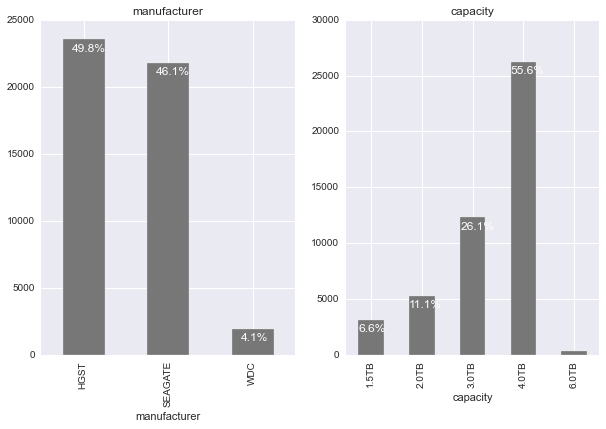

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)
for j, feat in enumerate(['manufacturer', 'capacity']):
    gp = df.groupby([feat]).size()
    ax = gp.plot(kind='bar', ax=axes[0,j], title=feat)
    for k, p in enumerate(gp):
        axes[0,j].annotate('{:.1%}'.format(p/gp.sum()), xy=(k,p), xycoords='data'
            ,xytext=(-12,-12), textcoords='offset points', color='w',fontsize=12)

**Observe:**  
+ HGST and Seagate drives are represented in similar total amounts, with WDC in the great minority
+ The most popular capacity drive is 4TB, with 3TB drives making up most of the remainder

## Drives by Manufacturer by Capacity

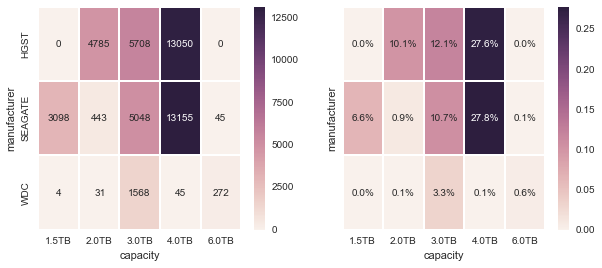

In [7]:
gp = df.groupby(['manufacturer','capacity']).size().unstack()
gp[pd.isnull(gp)] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4)
                         , squeeze=False, sharex=True, sharey=True)
ax = sns.heatmap(gp, annot=True, fmt='.0f', ax=axes[0,0])
ax = sns.heatmap(gp/gp.sum().sum(), annot=True, fmt='.1%', ax=axes[0,1])

**Observe:**
+ Again we see that Seagate and HGST are similarly matched for counts, and also represented similarly for capacities with each of their 4TB drive classes accounting for ~28% of the total.
+ Some imbalances become clear:
    + The overwhelming majority of 2 TB drives belong to HGST, and the 1.5TB drives are mostly Seagate
    + WDC is most often seen in the 3TB category, but most of the 6TB drives are WDC

---

# Simple distributions and ratios

## Drive failures by age

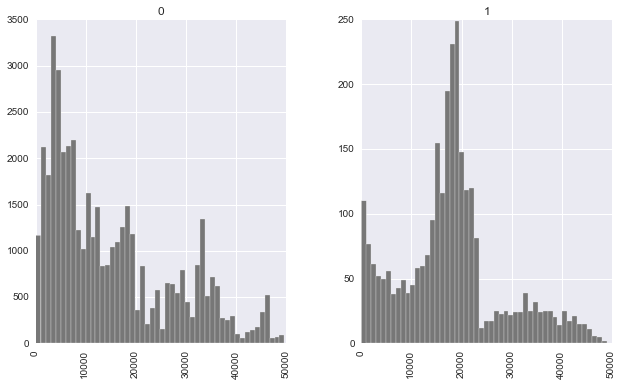

In [8]:
ax = df.hist(column='maxhours', by=['failed'], bins=50, sharex=True)

**Observe:** 
+ A dropoff in number of drives with increasing age, as you would expect for a survival analysis.
+ A very noticable peak in drive failures around the 20,000 hour mark
+ In fact the distribution of failures with time looks quite multi-modal, likely to be different group of failures in the data.

## Drive failures by age by manufacturer

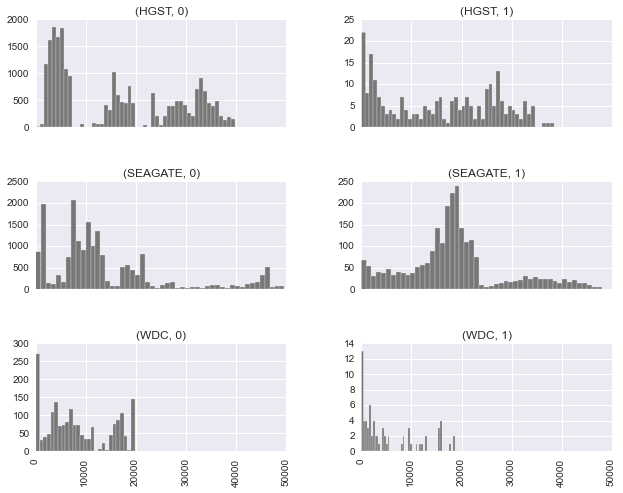

In [9]:
ax = df.hist(column='maxhours', by=['manufacturer','failed'], bins=50
             ,sharex=True, figsize=(10,8))

**Observe:**
+ That peak at 20,000 hours appears largely drive by Seagate drives
+ HGST appears quite 'lumpy' - possibly drives were bought and installed in well-defined batches
+ WDC has not been used for very long - only has values up to 20,000 hours

## Drive failures by manufacturer and capacity

In [10]:
gp = df.groupby(['manufacturer','capacity','failed']).size().unstack()
gp['prop'] = gp[1] / gp.sum(axis=1)
gp.reset_index(inplace=True)
gp.rename(columns={0:'active', 1:'failure'}, inplace=True)
gp

failed,manufacturer,capacity,active,failure,prop
0,HGST,2.0TB,4705,80,0.016719
1,HGST,3.0TB,5626,82,0.014366
2,HGST,4.0TB,12961,89,0.006820
3,SEAGATE,1.5TB,2554,544,0.175597
4,SEAGATE,2.0TB,391,52,0.117381
5,SEAGATE,3.0TB,3426,1622,0.321315
6,SEAGATE,4.0TB,12871,284,0.021589
7,SEAGATE,6.0TB,45,NaN,NaN
8,WDC,1.5TB,4,NaN,NaN
9,WDC,2.0TB,29,2,0.064516


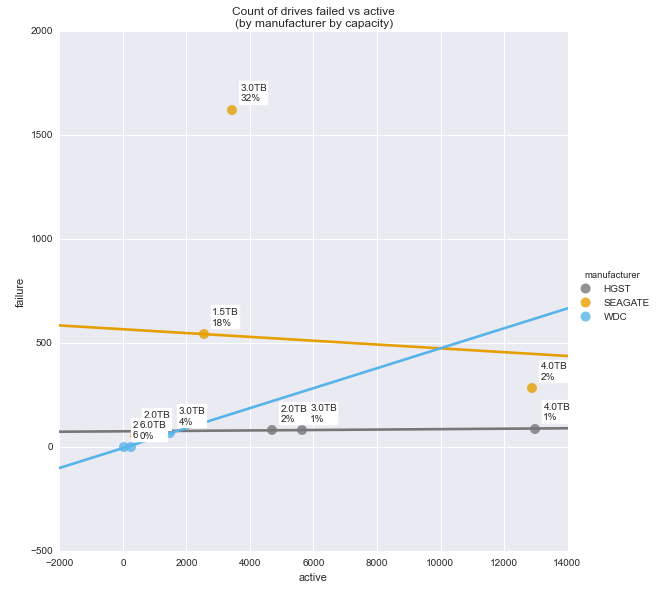

In [11]:
ax = sns.lmplot(data=gp, x='active', y='failure', hue='manufacturer'
                ,size=8, fit_reg=True, robust=True, scatter_kws={'s':100})
plt.title('Count of drives failed vs active\n(by manufacturer by capacity)')
for i, r in gp.iterrows():
    plt.annotate(s='{}\n{:.0%}'.format(r[1],r[4]), xy=(r[2],r[3]), xycoords='data'
                 ,xytext=(9,9), textcoords=('offset points'), axes=ax, backgroundcolor='w')

This is an interesting plot, **Observe:**  
+ Drives from WDC appear to have a linear failure ratio: an increase in the count of active drives yields increased failures
+ HGST drives appear to have a sub-linear relation, with their 4TB drive having the lowest failure ratio overall
+ Seagate drives are very mixed: the 4TB drive seems to be reliable, but the 3TB drive has an unusually high failure ratio of 32%.

---
<!--<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>-->
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>